In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
file_path_train = '../data/train_preprocess.tsv'
train_data = pd.read_csv(file_path_train, sep='\t', header=None)

file_path_val = '../data/valid_preprocess.tsv'
val_data = pd.read_csv(file_path_val, sep='\t', header=None)

file_path_test = '../data/test_preprocess.tsv'
test_data = pd.read_csv(file_path_test, sep='\t', header=None)

# Data Understanding
print('Data Train')
print('Data Size:', train_data.shape)
print('Sample Data:')
display(train_data.head())
print('\nSentiment Distribution:', train_data[1].value_counts())

print('\nData Validation')
print('Data Size:', val_data.shape)
print('Sample Data:')
display(val_data.head())

print('\nData Test')
print('Data Size:', test_data.shape)
print('Sample Data:')
display(test_data.head())

Data Train
Data Size: (11000, 2)
Sample Data:


,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative



Sentiment Distribution: 1
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64

Data Validation
Data Size: (1260, 2)
Sample Data:


,0,1
0,"meski masa kampanye sudah selesai , bukan bera...",neutral
1,tidak enak,negative
2,restoran ini menawarkan makanan sunda . kami m...,positive
3,lokasi di alun alun masakan padang ini cukup t...,positive
4,betapa bejad kader gerindra yang anggota dprd ...,negative



Data Test
Data Size: (500, 2)
Sample Data:


,0,1
0,kemarin gue datang ke tempat makan baru yang a...,negative
1,kayak nya sih gue tidak akan mau balik lagi ke...,negative
2,"kalau dipikir-pikir , sebenarnya tidak ada yan...",negative
3,ini pertama kalinya gua ke bank buat ngurusin ...,negative
4,waktu sampai dengan gue pernah disuruh ibu lat...,negative


In [38]:
# Label Splitting
x_train = train_data[0]
y_train = train_data[1]

print('x_train:\n')
display(x_train.head())
print('y_train:\n')
display(y_train.head())

x_val = val_data[0]
y_val = val_data[1]
print('x_val:\n')
display(x_val.head())
print('y_val:\n')
display(y_val.head())

x_test = test_data[0]
y_test = test_data[1]
print('x_test:\n')
display(x_test.head())
print('y_test:\n')
display(y_test.head())

x_train:



0    warung ini dimiliki oleh pengusaha pabrik tahu...
1    mohon ulama lurus dan k212 mmbri hujjah partai...
2    lokasi strategis di jalan sumatera bandung . t...
3    betapa bahagia nya diri ini saat unboxing pake...
4    duh . jadi mahasiswa jangan sombong dong . kas...
Name: 0, dtype: object

y_train:



0    positive
1     neutral
2    positive
3    positive
4    negative
Name: 1, dtype: object

x_val:



0    meski masa kampanye sudah selesai , bukan bera...
1                                           tidak enak
2    restoran ini menawarkan makanan sunda . kami m...
3    lokasi di alun alun masakan padang ini cukup t...
4    betapa bejad kader gerindra yang anggota dprd ...
Name: 0, dtype: object

y_val:



0     neutral
1    negative
2    positive
3    positive
4    negative
Name: 1, dtype: object

x_test:



0    kemarin gue datang ke tempat makan baru yang a...
1    kayak nya sih gue tidak akan mau balik lagi ke...
2    kalau dipikir-pikir , sebenarnya tidak ada yan...
3    ini pertama kalinya gua ke bank buat ngurusin ...
4    waktu sampai dengan gue pernah disuruh ibu lat...
Name: 0, dtype: object

y_test:



0    negative
1    negative
2    negative
3    negative
4    negative
Name: 1, dtype: object

In [39]:
# Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print('Encoded labels train:', y_train_encoded)
print('Encoded labels validation:', y_val_encoded)
print('Encoded labels test:', y_test_encoded)
print('Classes:', label_encoder.classes_)

Encoded labels train: [2 1 2 ... 1 0 2]
Encoded labels validation: [1 0 2 ... 0 0 2]
Encoded labels test: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [40]:
# Preprocessing
def lowercase (data):
    return data.str.lower()

def entity_masking (data):
    # Email masking
    email = re.compile(r'\w+@\w+\.[a-z]{3}')
    data_mask = data.apply(lambda x: email.sub('_email_', x))

    # Phone Number Masking
    phone = re.compile(r'(\+?\d{1,2}[-.\s]?)?(\(?\d{3}\)?[-.\s]?)?\d{3}[-.\s]?\d{4}')
    data_mask = data_mask.apply(lambda x: phone.sub('_phone_', x))
    
    return data_mask

def tokenization (data):
    data_tokenize = data.apply(lambda x: word_tokenize(x))
    return data_tokenize

def idn_spelling_correction (data):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    
    data_stem = []
    for sentence in data:
        stemmed_words = [stemmer.stem(word) for word in sentence]
        data_stem.append(stemmed_words)

    return data_stem

def remove_punctuation (data):
    data_nopunc = []

    for sentence in data:
        cleaned_sentence = [word for word in sentence if word not in string.punctuation]
        data_nopunc.append(cleaned_sentence)

    return data_nopunc

def preprocess (data):
    data = lowercase(data)
    data = entity_masking(data)
    data = tokenization(data)
    data = idn_spelling_correction(data)
    data = remove_punctuation(data)
    return data

In [41]:
# Preprocess Data
x_train_preprocessed = preprocess(x_train)
x_val_preprocessed = preprocess(x_val)
x_test_preprocessed = preprocess(x_test)

In [42]:
# Feature Extraction: Bag of Words TF-IDF
x_train_preprocessed = [' '.join(doc) for doc in x_train_preprocessed]
x_val_preprocessed = [' '.join(doc) for doc in x_val_preprocessed]
x_test_preprocessed = [' '.join(doc) for doc in x_test_preprocessed]

tfidf_vec = TfidfVectorizer(min_df=100, token_pattern=r'[a-zA-Z]+')
x_train_bow = tfidf_vec.fit_transform(x_train_preprocessed)
x_val_bow = tfidf_vec.transform(x_val_preprocessed)
x_test_bow = tfidf_vec.transform(x_test_preprocessed)

In [43]:
# Evaluation Metrics: Accuracy, Precision, Recall, F1-Score
def model_predict(model, x):
    y_pred = model.predict(x)

    return y_pred

def model_evaluation(y_pred, y_actual):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred, average='weighted')
    recall = recall_score(y_actual, y_pred, average='weighted')
    f1 = f1_score(y_actual, y_pred, average='weighted')

    return accuracy, precision, recall, f1

In [44]:
# Model Training
# Logistic Regression
print('Logistic Regression')
logreg = LogisticRegression(max_iter=1000)
logreg.fit(x_train_bow, y_train_encoded)

# Predictions validation data
y_pred = model_predict(logreg, x_val_bow)
print('Predictions:', y_pred)
print('Actual:', y_val_encoded)
print()

evaluation_metrics = model_evaluation(y_pred, y_val_encoded)
print('Accuracy:', evaluation_metrics[0])
print('Precision:', evaluation_metrics[1])
print('Recall:', evaluation_metrics[2])
print('F1-Score:', evaluation_metrics[3])

# Hyperparameter Tuning
print("\nHyperparameter Tuning for Logistic Regression")
param_grid_logreg = {
    'C': [0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5)
grid_search_logreg.fit(x_train_bow, y_train_encoded)
print('Best Parameters (LogReg):', grid_search_logreg.best_params_)
print('Best Score (LogReg):', grid_search_logreg.best_score_)

# Predictions validation data
y_pred = model_predict(grid_search_logreg, x_val_bow)
print('Predictions:', y_pred)
print('Actual:', y_val_encoded)
print()

evaluation_metrics = model_evaluation(y_pred, y_val_encoded)
print('Accuracy:', evaluation_metrics[0])
print('Precision:', evaluation_metrics[1])
print('Recall:', evaluation_metrics[2])
print('F1-Score:', evaluation_metrics[3])

Logistic Regression
Predictions: [0 2 2 ... 1 0 2]
Actual: [1 0 2 ... 0 0 2]

Accuracy: 0.823015873015873
Precision: 0.8216928033208631
Recall: 0.823015873015873
F1-Score: 0.822074686802914

Hyperparameter Tuning for Logistic Regression
Best Parameters (LogReg): {'C': 1, 'solver': 'lbfgs'}
Best Score (LogReg): 0.8291818181818181
Predictions: [0 2 2 ... 1 0 2]
Actual: [1 0 2 ... 0 0 2]

Accuracy: 0.823015873015873
Precision: 0.8216928033208631
Recall: 0.823015873015873
F1-Score: 0.822074686802914


In [45]:
# Random Forest Classifier
print('Random Forest')
rf = RandomForestClassifier()
rf.fit(x_train_bow, y_train_encoded)

# Prediction on validation set
y_pred = model_predict(rf, x_val_bow)
print('Predictions:', y_pred)
print('Actual:', y_val_encoded)
print()

evaluation_metrics = model_evaluation(y_pred, y_val_encoded)
print('Accuracy:', evaluation_metrics[0])
print('Precision:', evaluation_metrics[1])
print('Recall:', evaluation_metrics[2])
print('F1-Score:', evaluation_metrics[3])

# Hyperparameter Tuning
print("\nHyperparameter Tuning for Random Forest")
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_search_rf.fit(x_train_bow, y_train_encoded)
print('Best Parameters (RandomForest):', grid_search_rf.best_params_)
print('Best Score (RandomForest):', grid_search_rf.best_score_)

# Prediction on validation data
y_pred = model_predict(grid_search_rf, x_val_bow)
print('Predictions:', y_pred)
print('Actual:', y_val_encoded)
print()

evaluation_metrics = model_evaluation(y_pred, y_val_encoded)
print('Accuracy:', evaluation_metrics[0])
print('Precision:', evaluation_metrics[1])
print('Recall:', evaluation_metrics[2])
print('F1-Score:', evaluation_metrics[3])

Random Forest
Predictions: [0 0 2 ... 0 0 2]
Actual: [1 0 2 ... 0 0 2]

Accuracy: 0.8293650793650794
Precision: 0.82442876263046
Recall: 0.8293650793650794
F1-Score: 0.8250204133563441

Hyperparameter Tuning for Random Forest
Best Parameters (RandomForest): {'max_depth': 20, 'n_estimators': 100}
Best Score (RandomForest): 0.7983636363636364
Predictions: [0 0 2 ... 2 0 2]
Actual: [1 0 2 ... 0 0 2]

Accuracy: 0.8007936507936508
Precision: 0.8131416247179399
Recall: 0.8007936507936508
F1-Score: 0.786626176202558


In [47]:
# Support Vector Machine
print('Support Vector Machine')
svm = SVC()
svm.fit(x_train_bow, y_train_encoded)

# Prediction on validation data
y_pred = model_predict(svm, x_val_bow)
print('Predictions:', y_pred)
print('Actual:', y_val_encoded)
print()

evaluation_metrics = model_evaluation(y_pred, y_val_encoded)
print('Accuracy:', evaluation_metrics[0])
print('Precision:', evaluation_metrics[1])
print('Recall:', evaluation_metrics[2])
print('F1-Score:', evaluation_metrics[3])

# Hyperparameter Tuning
print("\nHyperparameter Tuning for Support Vector Machine")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_search_svm.fit(x_train_bow, y_train_encoded)
print('Best Parameters (SVM):', grid_search_svm.best_params_)
print('Best Score (SVM):', grid_search_svm.best_score_)

# Prediction on validation data
y_pred = model_predict(grid_search_svm, x_val_bow)
print('Predictions:', y_pred)
print('Actual:', y_val_encoded)
print()

evaluation_metrics = model_evaluation(y_pred, y_val_encoded)
print('Accuracy:', evaluation_metrics[0])
print('Precision:', evaluation_metrics[1])
print('Recall:', evaluation_metrics[2])
print('F1-Score:', evaluation_metrics[3])

Support Vector Machine
Predictions: [0 2 2 ... 1 0 2]
Actual: [1 0 2 ... 0 0 2]

Accuracy: 0.8468253968253968
Precision: 0.8468943206791202
Recall: 0.8468253968253968
F1-Score: 0.8447536477080531

Hyperparameter Tuning for Support Vector Machine
Best Parameters (SVM): {'C': 10, 'kernel': 'rbf'}
Best Score (SVM): 0.8569090909090908
Predictions: [0 0 2 ... 1 0 2]
Actual: [1 0 2 ... 0 0 2]

Accuracy: 0.8539682539682539
Precision: 0.8526444791544027
Recall: 0.8539682539682539
F1-Score: 0.8527648498618379


Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 0 2 0 2 2 2 0 0 2 0 2 2 1 2 2 0 1 2 2 2 2 2 2 2 0 0 0 2 0 0 2 2 2 2 2
 2 2 2 2 0 2 2 2 2 0 0 2 2 2 2 2 2 2 0 2 0 2 0 2 2 2 2 2 2 2 0 0 2 0 0 2 2
 2 2 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2 2 2 2 2 0 2 1 1 0 0 0 0 1
 0 0 0 0 2 1 1 1 0 1 1 1 2 2 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 2 0 0 0 1 2 0
 0 1 2 1 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 0 0 0 2 2 2 2 0 2 0 0 0 2 2 2 2 0 0 2 0 0 0 2 0 0 2 2 2 0 0
 0 2 0 0 2 0 2 0 2 0 0 0 2 0 2 0 0 0 2 0 0 0 2 0 2 2 0 0 2 2 2 2 0 2 2 0 0
 2 2 0 2 2 2 0 0 0 0 2 0 2 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 2 0 0
 0 2 0 2 2 

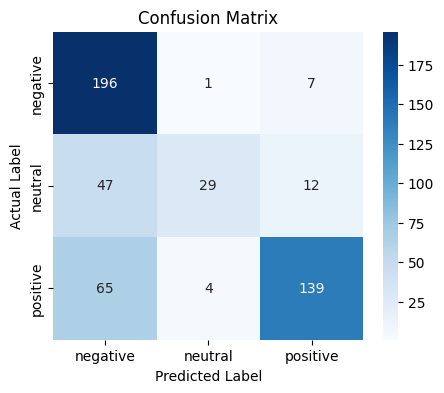

Accuracy: 0.728
Precision: 0.775728694239491
Recall: 0.728
F1-Score: 0.7120252732240437


In [50]:
# Data Test Prediction
y_test_pred = model_predict(grid_search_svm, x_test_bow)
print('Predictions:\n', y_test_pred)
print('Actual:\n', y_test_encoded)
print()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

# Evaluation Metrics
evaluation_metrics = model_evaluation(y_test_pred, y_test_encoded)
print('Accuracy:', evaluation_metrics[0])
print('Precision:', evaluation_metrics[1])
print('Recall:', evaluation_metrics[2])
print('F1-Score:', evaluation_metrics[3])